In [3]:
q= '''
SELECT *
FROM
    (SELECT *,
    row_number()
    OVER
        (PARTITION BY "open_time"
        ORDER BY "close_time" DESC, Api_Invocation_Time DESC, write_time DESC)
    AS row_number
    FROM "sagemaker_featurestore"."btcpricedata_1704246894")
WHERE row_number = 1 ORDER BY close_time ASC;
'''

In [4]:
from sagemaker.feature_store.feature_group import FeatureGroup
import boto3
import pandas as pd
import numpy as np
import io
from sagemaker.session import Session
from sagemaker import get_execution_role
from matplotlib import pyplot as plt
from keras.layers import LSTM,Dropout,Input,Dense
from numpy import array
from keras.models import Sequential

sagemaker_session = Session()

feature_group = FeatureGroup(name = 'BtcPriceData')

query = feature_group.athena_query()

table = query.table_name
table
default_s3_bucket_name = 'binance-btc-prices'

2024-01-11 19:53:16,507 INFO: Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
2024-01-11 19:53:18,757 INFO: Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2024-01-11 19:53:18,881 INFO: Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [5]:
# run Athena query. The output is loaded to a Pandas dataframe.
dataset = pd.DataFrame()
query.run(query_string=q, output_location='s3://'+default_s3_bucket_name+'/query_results/')
query.wait()
dataset = query.as_dataframe()

2024-01-11 19:53:19,749 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:24,815 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:29,870 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:34,919 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:39,973 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:45,020 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:50,065 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:53:55,112 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:54:00,163 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 is being executed.
2024-01-11 19:54:05,210 INFO: Query 309e58b0-0b8d-4d5a-867d-b893511ed626 successfully executed.


In [6]:
dataset['open_time'] = pd.to_datetime(dataset['open_time'], unit='ms').dt.strftime('%Y-%m-%d %T')
dataset

,open_time,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,open_price,write_time,api_invocation_time,is_deleted,row_number
0,2019-09-09 00:00:00,10392.41,10376.45,10390.08,27.884150,1.567987e+09,2.896169e+05,626.0,12.492958,10381.24,2024-01-08 18:11:09.934,2024-01-08 18:05:58.000,False,1
1,2019-09-09 00:05:00,10393.94,10368.87,10372.31,36.750216,1.567988e+09,3.814708e+05,614.0,22.195335,10390.74,2024-01-08 18:11:07.429,2024-01-08 18:05:58.000,False,1
2,2019-09-09 00:10:00,10386.24,10368.88,10374.20,38.888045,1.567988e+09,4.035607e+05,640.0,19.145836,10372.31,2024-01-08 18:11:30.173,2024-01-08 18:05:58.000,False,1
3,2019-09-09 00:15:00,10387.83,10368.89,10384.89,24.997683,1.567988e+09,2.593937e+05,712.0,11.799247,10374.18,2024-01-08 18:11:10.880,2024-01-08 18:05:58.000,False,1
4,2019-09-09 00:20:00,10396.00,10382.40,10394.20,18.551736,1.567989e+09,1.927592e+05,571.0,9.729698,10386.25,2024-01-08 18:11:06.932,2024-01-08 18:05:58.000,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455729,2024-01-11 15:40:00,47444.33,46885.00,47218.69,1506.346990,1.704988e+09,7.102140e+07,42815.0,699.344620,47336.01,2024-01-11 16:05:45.733,2024-01-11 16:00:48.000,False,1
455730,2024-01-11 15:45:00,47232.00,46641.28,46752.60,1399.431060,1.704988e+09,6.564254e+07,35141.0,611.596750,47218.69,2024-01-11 16:05:39.781,2024-01-11 16:00:48.000,False,1
455731,2024-01-11 15:50:00,46853.43,46463.19,46698.58,1493.366130,1.704988e+09,6.971632e+07,35935.0,738.648210,46752.60,2024-01-11 16:05:46.367,2024-01-11 16:00:48.000,False,1
455732,2024-01-11 15:55:00,46785.64,46568.42,46783.78,690.924300,1.704989e+09,3.225020e+07,18130.0,346.549950,46698.59,2024-01-11 16:05:48.062,2024-01-11 16:00:48.000,False,1


In [7]:
#dataset.to_csv('btc_prices.csv')

In [8]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
n_steps = 24

In [10]:
X,y  = split_sequence(sequence = dataset.close_price, n_steps = n_steps)

In [11]:
X = X.reshape(X.shape[0],-1,1)

In [12]:
train_index =  round(y.shape[0] * 0.80)
val_index   =  round(y.shape[0] * 0.90)

In [13]:
X.shape

(455710, 24, 1)

In [14]:
X_train = X[:train_index]
y_train = y[:train_index]
X_val = X[train_index  : val_index]
y_val = y[train_index  : val_index]
X_test = X[val_index:]
y_test = y[val_index:]

In [15]:
X_train.shape

(364568, 24, 1)

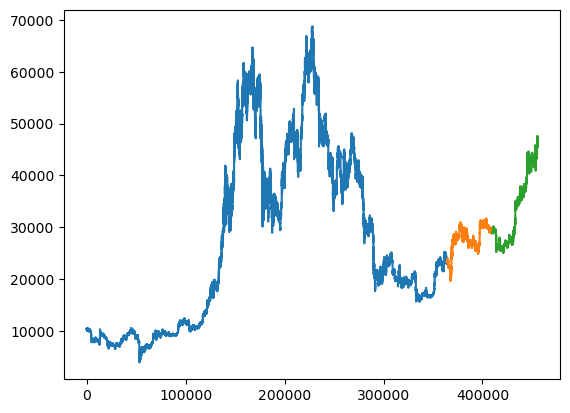

In [53]:
plt.plot(np.arange(len(y_train)),y_train)
plt.plot( len(y_train) + np.arange(len(y_val)),y_val)
plt.plot(len(y_train)  + len(y_val) + np.arange(len(y_test)),y_test)

In [90]:
### MLP
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=n_steps))
model.add(Dense(100, activation='relu',))
model.add(Dense(1))
model.compile(optimizer='adam' ,loss='mse', metrics = ['mae'])


In [125]:
hist = model.fit(X_train, y_train, validation_data = (X_val,y_val) ,batch_size = 16256, epochs=10, verbose=1)


Epoch 1/10
23/23 [==============================] - 0s 6ms/step - loss: 8574.1611 - mae: 54.4914 - val_loss: 1863.7742 - val_mae: 29.1460
Epoch 2/10
23/23 [==============================] - 0s 5ms/step - loss: 6944.3530 - mae: 43.9978 - val_loss: 4297.0825 - val_mae: 56.4856
Epoch 3/10
23/23 [==============================] - 0s 4ms/step - loss: 9978.6592 - mae: 61.2864 - val_loss: 1525.7754 - val_mae: 23.1336
Epoch 4/10
23/23 [==============================] - 0s 5ms/step - loss: 7866.7300 - mae: 49.9245 - val_loss: 1557.7646 - val_mae: 23.8160
Epoch 5/10
23/23 [==============================] - 0s 5ms/step - loss: 10472.9668 - mae: 61.5715 - val_loss: 2142.8289 - val_mae: 33.3459
Epoch 6/10
23/23 [==============================] - 0s 5ms/step - loss: 8277.5303 - mae: 51.3537 - val_loss: 1526.9185 - val_mae: 23.1032
Epoch 7/10
23/23 [==============================] - 0s 4ms/step - loss: 6792.4785 - mae: 42.9168 - val_loss: 1566.7241 - val_mae: 23.9878
Epoch 8/10
23/23 [===============

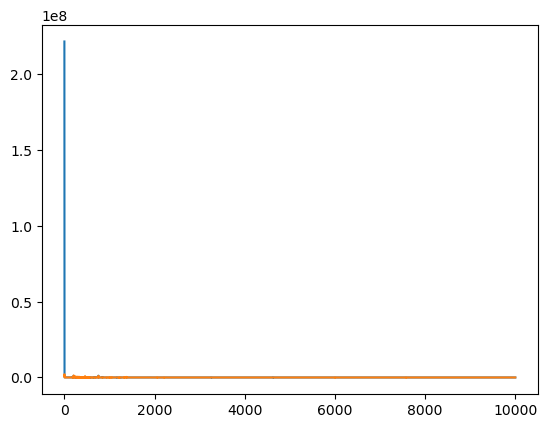

In [92]:
loss, val_loss = hist.history['loss'],hist.history['val_loss']
plt.plot(np.arange(len(loss)),loss)
plt.plot(np.arange(len(val_loss)),val_loss)

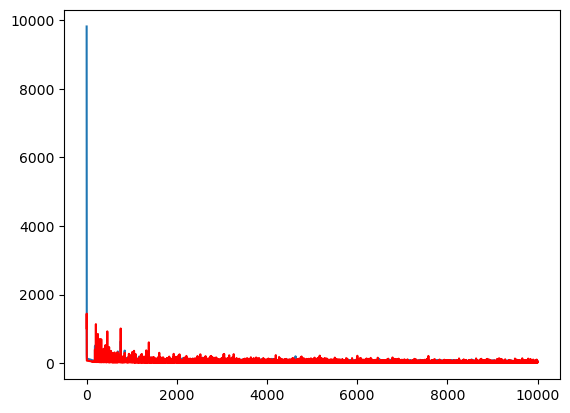

In [93]:
mae, val_mae = hist.history['mae'],hist.history['val_mae']
plt.plot(np.arange(len(mae)),mae)
plt.plot(np.arange(len(mae)),val_mae, 'r')


In [94]:
model.predict(X_test[:10]).reshape(-1)

1/1 [==============================] - 0s 48ms/step


array([29009.582, 29000.07 , 29003.443, 29022.13 , 29038.322, 29039.578,
       29046.607, 29049.646, 29053.184, 29053.768], dtype=float32)

11392/11392 [==============================] - 10s 868us/step


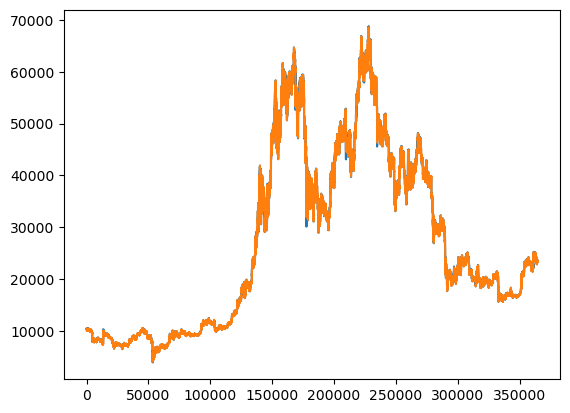

In [95]:
preds_train = model.predict(X_train).reshape(-1)
plt.plot(np.arange(len(y_train)),y_train)
plt.plot(np.arange(len(preds_train)), preds_train)

1424/1424 [==============================] - 1s 872us/step


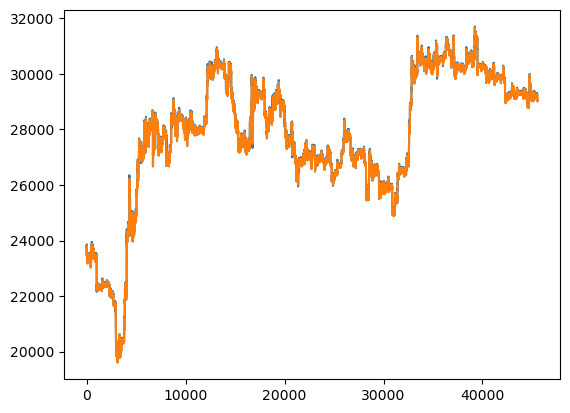

In [96]:
preds_val = model.predict(X_val).reshape(-1)
plt.plot(np.arange(len(y_val)),y_val)
plt.plot(np.arange(len(preds_val)), preds_val)

1424/1424 [==============================] - 1s 872us/step


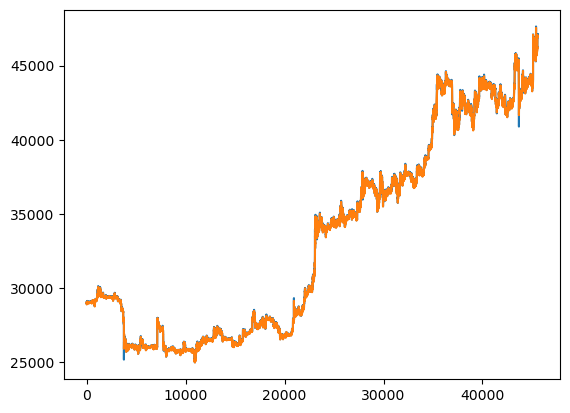

In [97]:
preds_test = model.predict(X_test).reshape(-1)
plt.plot(np.arange(len(preds_test)),y_test)
plt.plot(np.arange(len(preds_test)), preds_test)

In [101]:
def predict_hours(model,initial_sequence,n_steps = 24 ,h = 2):
    recursive_preds = []
    for i in range(h * 12):
        input_ = initial_sequence.reshape(1,n_steps)
        pred = model.predict(input_,verbose = 0)[0][0]
        recursive_preds.append(pred)
        initial_sequence = np.append(initial_sequence,pred)[-n_steps:]
    return recursive_preds
n = 100
initial_sequence = y_test[n:n + n_steps]
preds = predict_hours(model, initial_sequence,n_steps = n_steps, h = 2)


In [120]:
!pip install hopsworks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 13.2 MB/s eta 0:00:00
     ━

In [1]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
import hopsworks
project = hopsworks.login()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) DD2223_lab1
	 (2) project0



Enter project to access:  1



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/206996


In [18]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="btc-predictor-mlp-2"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# # Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
# #joblib.dump(model, model_dir + "/lstm_model.h5")
model.save(model_dir + "/mlp.keras")
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
model_lstm = mr.python.create_model(
    name="mlpModel", 
    metrics={"val_loss" : hist.history['val_loss'][-1],"val_mae" : hist.history['val_mae'][-1] },
    model_schema=model_schema,
    description="BTC price Predictor",
    version = 2
    
)

# Upload the model to the model registry, including all files in 'model_dir'
model_lstm.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/328038 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/221 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/206996/models/mlpModel/2


Model(name: 'mlpModel', version: 2)

In [ ]:
print(mr.python.create_model.__doc__)